# OIB to OME-Zarr Conversion and Visualization Notebook

Performs conversion and add both image and ROI metadata to the OME-Zarr file

## Install Libraries

In [1]:
print("Installing necessary libraries...")
!pip install oiffile ome-zarr read_roi > /dev/null 2>&1
print("Libraries installed successfully.")

Installing necessary libraries...
Libraries installed successfully.


## Import Libraries

In [2]:
import os
import oiffile
import numpy as np
import zarr
from ome_zarr.io import parse_url
import matplotlib.pyplot as plt
from read_roi import read_roi_zip

## Define File Paths

In [6]:

## Example 1
#directory_path = '/home/jovyan/LNMA/bravoa/data/New2 Fig para colocalizacion Manders-Mito'
#filename = '1-Cry11 2mg 2h MitoT 750nM 60xmed-post 3.5 Z copy.oib'
#rois_name = 'RoiSet-1-Cry11 2mg 2h MitoT 750nM 60xmed-post 3.5 Z copy.zip'

# Example 2
directory_path = '/home/jovyan/LNMA/bravoa/data/Seleccion ROIs circulares RE'
filename = '1-Cry11 2mg 2h RE 2mM ant 60X Z3.5 copy 2.oib'
rois_name = 'RoiSet-1-Cry11 2mg 2h RE 2mM ant 60X Z3.5 copy 2.zip'

file_path = os.path.join(directory_path, filename)
rois_path = os.path.join(directory_path, rois_name)

oib_file_path = file_path
ome_zarr_path = f'{file_path[:-4]}.zarr'


## Load Image Data and Metadata from OIB

In [7]:
with oiffile.OifFile(oib_file_path) as oib:
    image_data = oib.asarray()  # Load image data
    all_metadata = dict(oib.mainfile)  # Retrieve all metadata as a dictionary

# Display a portion of the metadata for verification
print("Sample Metadata:", {k: all_metadata[k] for k in list(all_metadata)[:5]})

Sample Metadata: {'2D Display': {'Center Point Type': '0', 'ChAutoFit': '1', 'Columns': '2', 'Grid': '0', 'H Axis': 'C', 'Image Size Auto': '1', 'L End Pos': '-1', 'L Interval': '1', 'L Start Pos': '1', 'Rows': '2', 'Show Center Point': '0', 'ShowDivisionsOnScale': 1, 'ShowLabelOnColorBar': 1, 'ShowLabelOnScale': 1, 'T End Pos': '-1', 'T Interval': '1', 'T Start Pos': '1', 'Tile Type': '1', 'V Axis': 'C', 'View 1': '1', 'View 2': '2', 'View 3': '3', 'View 4': '4', 'View Cnt': '4', 'View Max CH': '4', 'Z End Pos': '-1', 'Z Interval': '1', 'Z Start Pos': '1'}, 'Acquisition Parameters Common': {'Acquisition Device': 'FV1000', 'AcquisitionMode': 1, 'Assign Dye Manually': 0, 'Auto C.A': 1, 'Auto HV': 0, 'EveryTrigger Enable': 0, 'FindMode': 1, 'GUI StartScanMode': 1, 'GUI StopScanMode': 1, 'ImageCaputreDate': '2023-11-09 12:52:16', 'ImageCaputreDate+MilliSec': 287, 'IntegrationCount': 4, 'IntegrationType': 'Line Kalman', 'LaserTransmissivity01': 2.5, 'LaserTransmissivity02': 3.5, 'LaserTran

## Load ROIs from the .zip file

In [8]:
rois = read_roi_zip(rois_path)
#rois

## Structure ROI data for storage in OME-Zarr

In [9]:
roi_metadata = [
    {
        "name": roi_name,
        "type": roi_data.get("type"),
        "left": roi_data.get("left"),
        "top": roi_data.get("top"),
        "width": roi_data.get("width"),
        "height": roi_data.get("height"),
        "arc_size": roi_data.get("arc_size"),
        "position": roi_data.get("position"),
    }
    for roi_name, roi_data in rois.items()
]

## Format Image Data for OME-Zarr

In [10]:
# Ensure data shape is in (T, C, Z, Y, X) format
while image_data.ndim < 5:
    image_data = np.expand_dims(image_data, axis=0)  # Add dimensions as needed

# Convert the data to a numpy array (if not already)
image_data = np.asarray(image_data)

# Reorder data
image_data = image_data.transpose(0, 2, 1, 3, 4)


## Remove Existing Zarr Store (if exists)

In [11]:
if os.path.exists(ome_zarr_path):
    import shutil
    shutil.rmtree(ome_zarr_path)

## Save Image Data and Metadata to OME-Zarr

In [12]:
store = parse_url(ome_zarr_path, mode="w").store
root = zarr.group(store=store)
dataset = root.create_dataset("image_data", data=image_data, chunks=True)

# Save image metadata and ROI metadata as attributes
root.attrs["image_metadata"] = all_metadata
root.attrs["roi_metadata"] = roi_metadata

print("Conversion complete. The OME-Zarr file is saved with all metadata.")

Conversion complete. The OME-Zarr file is saved with all metadata.


## Load and Display Metadata from OME-Zarr

In [13]:
# Load the OME-Zarr file
root = zarr.open(ome_zarr_path, mode="r")

# Display metadata
image_metadata = root.attrs.get("image_metadata", {})
roi_metadata = root.attrs.get("roi_metadata", {})

#print("Image Metadata:", image_metadata)
#print("ROIs Metadata:", roi_metadata)

image_date = image_metadata.get('Acquisition Parameters Common', {}).get('ImageCaputreDate', 'Date not found')
print("Image Date:", image_date)

channel_1 = image_metadata.get('Channel 1 Parameters', {}).get('DyeName', 'DyeName not found')
channel_2 = image_metadata.get('Channel 2 Parameters', {}).get('DyeName', 'DyeName not found')
channel_3 = image_metadata.get('Channel 3 Parameters', {}).get('DyeName', 'DyeName not found')
print("Channel 1", channel_1)
print("Channel 2", channel_2)
print("Channel 3", channel_3)
# Assuming roi_metadata is a list of dictionaries with each ROI's information
roi_names = [roi.get('name') for roi in roi_metadata]

# Print all ROI names
for i, roi_name in enumerate(roi_names):
    print(f"ROI {i} Name:", roi_name)

Image Date: 2023-11-09 12:52:16
Channel 1 DAPI
Channel 2 Alexa Fluor 568
Channel 3 Alexa Fluor 647
ROI 0 Name: 0002-0155-0077-VExt
ROI 1 Name: 0002-0098-0200-VExt
ROI 2 Name: 0002-0070-0320-VExt
ROI 3 Name: 0002-0082-0394-VExt
ROI 4 Name: 0002-0127-0476-VExt
ROI 5 Name: 0002-0138-0628-VExt
ROI 6 Name: 0002-0116-0704-VExt
ROI 7 Name: 0002-0078-0652-VExt
ROI 8 Name: 0002-0104-0787-VExt
ROI 9 Name: 0002-0127-0904-VExt
ROI 10 Name: 0002-0141-0984-VExt
ROI 11 Name: 0002-0041-0591-VExt


## Access and Visualize the DIC Image in the OME-Zarr File

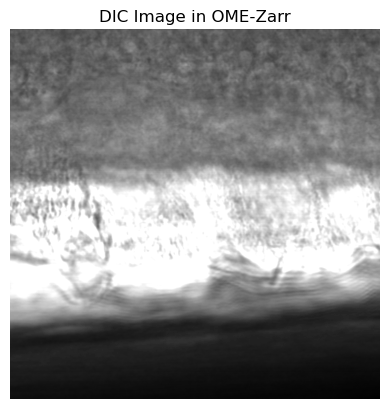

In [14]:
# Access the DIC image slice (T=0, C=3, Z=0), adjust as needed based on dimensionality
DIC_image = root["image_data"][0, 3, 0, :, :]  # Assuming (T, C, Z, Y, X) format
# Display the first image
plt.imshow(DIC_image, cmap="gray")
plt.title("DIC Image in OME-Zarr")
plt.axis("off")
plt.show()